In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Mapping of ticker symbols to entity IDs
ticker_to_entity_id = {
    'MSTR': 1,
    'MARA': 4
}

# Function to fetch historical Bitcoin prices
def get_historical_bitcoin_prices(start_date, end_date):
    btc = yf.Ticker("BTC-USD")
    btc_hist = btc.history(start=start_date, end=end_date)
    btc_hist = btc_hist[['Open']].rename(columns={'Open': 'BTC Price'})
    btc_hist.reset_index(inplace=True)
    btc_hist['Date'] = pd.to_datetime(btc_hist['Date']).dt.tz_localize(None)
    return btc_hist

# Function to fetch historical Bitcoin holdings and interpolate data to daily frequency
def get_historical_bitcoin_holdings_daily(ticker):
    entity_id = ticker_to_entity_id.get(ticker)
    if not entity_id:
        raise ValueError(f"Ticker {ticker} not found in the mapping.")
    
    url = f"https://bitcointreasuries.net/entities/{entity_id}"
    response = requests.get(url)
    html_content = response.content

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the table with the Bitcoin holdings
    table = soup.find("table", {"class": "relative min-w-full divide-y divide-gray-300 font-mono text-xs xs:text-base"})

    # Extract the rows from the table
    rows = table.find_all("tr", class_="cursor-pointer")

    # Extract the date and Bitcoin balance from each row
    holdings = []
    for row in rows:
        cols = row.find_all("td")
        if len(cols) > 2:
            date = cols[1].find('time').get('datetime')
            btc_balance = cols[2].get_text(strip=True)
            btc_balance = int(btc_balance.replace(',', ''))
            holdings.append((date, btc_balance))

    # Convert to DataFrame
    df = pd.DataFrame(holdings, columns=['Date', 'BTC Balance'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    complete_date_range = pd.date_range(start=df.index.min(), end=pd.Timestamp.today())
    df = df.reindex(complete_date_range)
    df['BTC Balance'] = df['BTC Balance'].ffill()
    df = df['2022-01-01':]
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Date'}, inplace=True)

    return df

# Function to calculate market value
def calculate_market_value(holdings_df, prices_df):
    # Merge holdings with prices
    merged_df = pd.merge(holdings_df, prices_df, on='Date', how='left')
    # Calculate market value
    merged_df['Market Value'] = merged_df['BTC Balance'] * merged_df['BTC Price']
    return merged_df

# Function to fetch historical stock data and shares outstanding
def get_historical_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(start=start_date, end=end_date)
    shares_outstanding = stock.get_shares_full(start=start_date, end=end_date)
    
    stock_hist = stock_hist[['Close']].rename(columns={'Close': 'Stock Price'})
    stock_hist.reset_index(inplace=True)
    stock_hist['Date'] = pd.to_datetime(stock_hist['Date']).dt.tz_localize(None)
    
    shares_outstanding = shares_outstanding.reset_index()
    shares_outstanding.columns = ['Date', 'Shares Outstanding']
    shares_outstanding['Date'] = pd.to_datetime(shares_outstanding['Date']).dt.tz_localize(None)
    
    # Merge shares outstanding with stock price data
    stock_hist = pd.merge(stock_hist, shares_outstanding, on='Date', how='left')
    
    # Forward fill missing values for shares outstanding
    stock_hist['Shares Outstanding'] = stock_hist['Shares Outstanding'].ffill()
    
    # Calculate market cap
    stock_hist['Market Cap'] = stock_hist['Stock Price'] * stock_hist['Shares Outstanding']
    
    return stock_hist[['Date', 'Market Cap']]

# Function to merge market cap data
def merge_market_cap(holdings_df, stock_df):
    # Merge holdings with stock market cap
    merged_df = pd.merge(holdings_df, stock_df, on='Date', how='left')
    
    # Remove duplicate dates, keep the first occurrence
    merged_df = merged_df[~merged_df['Date'].duplicated(keep='first')]
    
    # Forward fill missing market cap values for weekends
    merged_df['Market Cap'] = merged_df['Market Cap'].ffill()
    return merged_df

# Function to calculate premium
def calculate_premium(final_df):
    final_df['Premium'] = final_df['Market Cap'] / final_df['Market Value']
    return final_df

# Function to plot Bitcoin price and premium
def plot_bitcoin_price_and_premium(df, entity_name):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Bitcoin Price', color='tab:blue')
    ax1.plot(df['Date'], df['BTC Price'], color='tab:blue', label='BTC Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Premium', color='tab:red')
    ax2.plot(df['Date'], df['Premium'], color='tab:red', label='Premium')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'{entity_name} Bitcoin Price and Premium')
    ax1.xaxis.set_tick_params(rotation=45)
    ax1.grid(True)
    ax2.grid(False)

    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

In [5]:
# Main execution
# Fetch the historical Bitcoin holdings with daily data points for MicroStrategy and Marathon Digital
microstrategy_holdings = get_historical_bitcoin_holdings_daily('MSTR')
marathon_holdings = get_historical_bitcoin_holdings_daily('MARA')

# Fetch the historical Bitcoin prices
start_date = min(microstrategy_holdings['Date'].min(), marathon_holdings['Date'].min())
end_date = pd.Timestamp.today()
bitcoin_prices = get_historical_bitcoin_prices(start_date, end_date)

# Fetch the historical stock data and shares outstanding
microstrategy_stock_data = get_historical_stock_data('MSTR', start_date, end_date)
marathon_stock_data = get_historical_stock_data('MARA', start_date, end_date)

# Calculate the market value for each date for MicroStrategy
microstrategy_market_values = calculate_market_value(microstrategy_holdings, bitcoin_prices)

# Calculate the market value for each date for Marathon Digital
marathon_market_values = calculate_market_value(marathon_holdings, bitcoin_prices)

# Merge market cap data
microstrategy_final = merge_market_cap(microstrategy_market_values, microstrategy_stock_data)
marathon_final = merge_market_cap(marathon_market_values, marathon_stock_data)

# Calculate premium
microstrategy_final = calculate_premium(microstrategy_final)
marathon_final = calculate_premium(marathon_final)

MicroStrategy Historical Bitcoin Holdings, Market Values, Market Cap, and Premium:
          Date  BTC Balance     BTC Price  Market Value    Market Cap  \
0   2022-01-01     124391.0  46311.746094  5.760764e+09           NaN   
1   2022-01-02     124391.0  47680.925781  5.931078e+09           NaN   
2   2022-01-03     124391.0  47343.542969  5.889111e+09  6.261556e+09   
3   2022-01-04     124391.0  46458.851562  5.779063e+09  6.180911e+09   
4   2022-01-05     124391.0  45899.359375  5.709467e+09  5.710167e+09   
..         ...          ...           ...           ...           ...   
881 2024-05-11     214400.0  60793.355469  1.303410e+10  2.045158e+10   
882 2024-05-12     214400.0  60793.503906  1.303413e+10  2.045158e+10   
883 2024-05-13     214400.0  61451.218750  1.317514e+10  2.210009e+10   
884 2024-05-14     214400.0  62914.046875  1.348877e+10  2.269092e+10   
885 2024-05-15     214400.0           NaN           NaN  2.269092e+10   

      Premium  
0         NaN  
1       

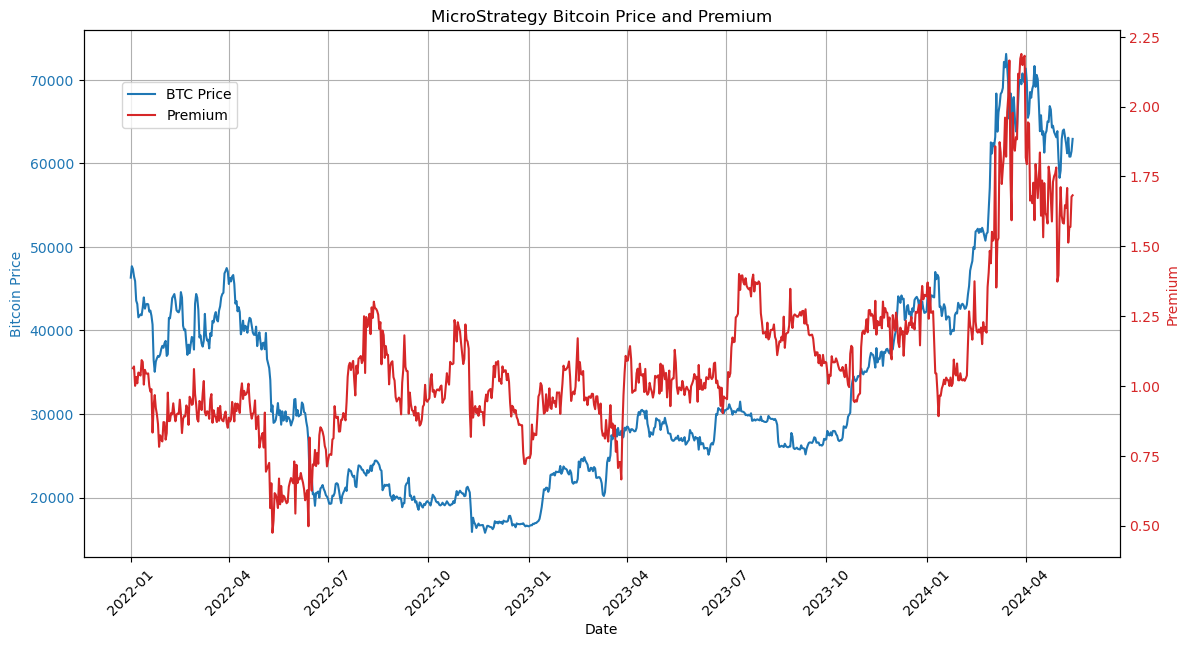

In [9]:
# Print the results for MicroStrategy
print("MicroStrategy Historical Bitcoin Holdings, Market Values, Market Cap, and Premium:")
print(microstrategy_final)
# Plot Bitcoin price and premium for MicroStrategy
plot_bitcoin_price_and_premium(microstrategy_final, 'MicroStrategy')

Marathon Digital Historical Bitcoin Holdings, Market Values, Market Cap, and Premium:
          Date  BTC Balance     BTC Price  Market Value    Market Cap  \
0   2022-01-01       8133.0  46311.746094  3.766534e+08           NaN   
1   2022-01-02       8133.0  47680.925781  3.877890e+08           NaN   
2   2022-01-03       8133.0  47343.542969  3.850450e+08           NaN   
3   2022-01-04       8133.0  46458.851562  3.778498e+08           NaN   
4   2022-01-05       8133.0  45899.359375  3.732995e+08           NaN   
..         ...          ...           ...           ...           ...   
869 2024-05-11      17631.0  60793.355469  1.071848e+09  4.683393e+09   
870 2024-05-12      17631.0  60793.503906  1.071850e+09  4.683393e+09   
871 2024-05-13      17631.0  61451.218750  1.083446e+09  4.813711e+09   
872 2024-05-14      17631.0  62914.046875  1.109238e+09  4.900925e+09   
873 2024-05-15      17631.0           NaN           NaN  4.900925e+09   

      Premium  
0         NaN  
1    

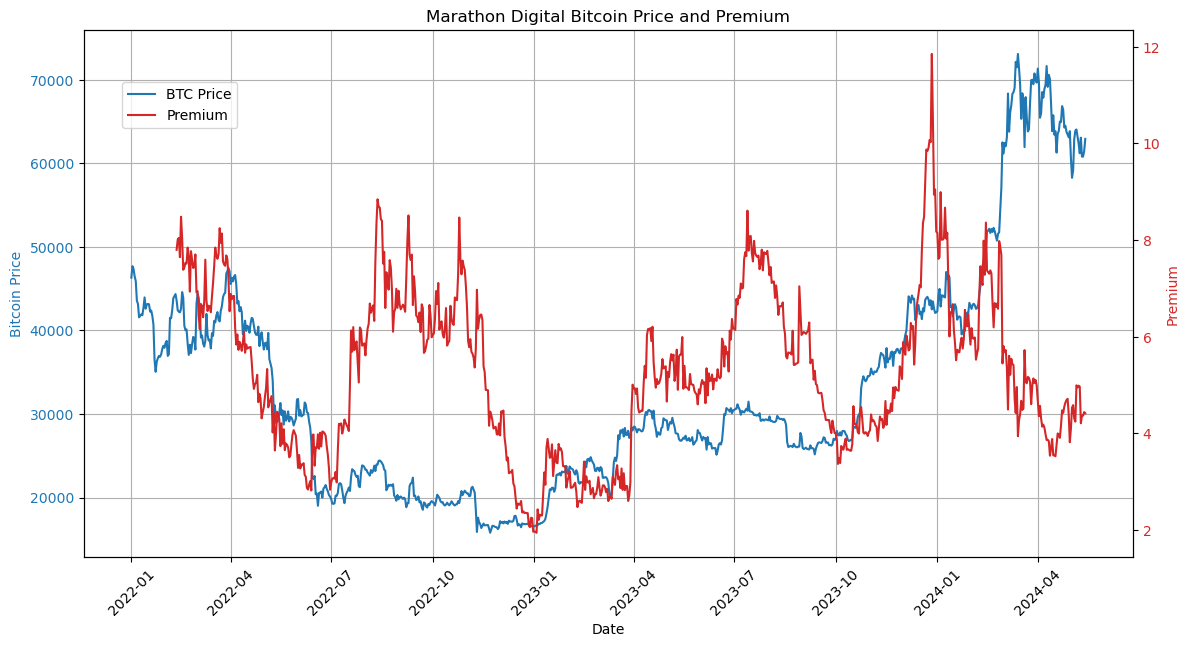

In [10]:
# Print the results for Marathon Digital
print("Marathon Digital Historical Bitcoin Holdings, Market Values, Market Cap, and Premium:")
print(marathon_final)
# Plot Bitcoin price and premium for Marathon Digital
plot_bitcoin_price_and_premium(marathon_final, 'Marathon Digital')